In [1]:
from calculations.damage_calculator import damage_calc, raise_for_invalid_inputs, damage_calc_for_target_damage
from calculations.dataclasses_and_enums import OneTalents, SevenTalents, SixteenTalents

In [8]:
bb_time_series, bb_damage_series = damage_calc(
    10,
    4,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFILLUSION,
    seven_talent=SevenTalents.BURNINGBLADE,
)
cb_time_series, cb_damage_series = damage_calc(
    10,
    4,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFTHEBLADE,
    seven_talent=SevenTalents.CRUSHINGBLOWS,
)
pp_time_series, pp_damage_series = damage_calc(
    10,
    4,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFTHEWIND,
    seven_talent=SevenTalents.BURNINGBLADE,
)

32.56537426820358 CRIT clone
65.13074853640715 CRIT clone
447.1005826597494 CRIT samuro
479.665956927953 CRIT -W clone
512.2313311961566 CRIT -W clone
894.2011653194988 CRIT -W samuro
910.4838524536007 AA clone
926.7665395877025 AA clone
1117.7514566493737 AA samuro
1134.0341437834754 AA clone
1150.3168309175771 AA clone
1341.3017479792484 AA samuro
1357.58443511335 AA clone
1373.8671222474518 AA clone
1564.852039309123 AA samuro
1597.4174135773267 CRIT clone
1629.9827878455303 CRIT clone
2011.9526219688726 CRIT samuro
2028.2353091029743 AA clone
2044.517996237076 AA clone
2235.502913298747 AA samuro
2251.7856004328487 AA clone
2268.0682875669504 AA clone
2459.0532046286216 AA samuro
24.42403070115268 CRIT clone
50.06926293736299 CRIT clone
315.8027169659042 CRIT samuro
343.8903522722298 CRIT -W clone
371.97798757855537 CRIT -W clone
667.1535004341224 CRIT -W samuro
685.8785906383395 AA clone
704.6036808425565 AA clone
912.9628663876626 AA samuro
931.6879565918797 AA clone
950.41304679

In [4]:
bb_time_series_for_kill_target, bb_damage_series_for_kill_target = damage_calc_for_target_damage(
    10,
    2470,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFILLUSION,
    seven_talent=SevenTalents.BURNINGBLADE,
)
cb_time_series_for_kill_target, cb_damage_series_for_kill_target = damage_calc_for_target_damage(
    10,
    2470,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFTHEBLADE,
    seven_talent=SevenTalents.CRUSHINGBLOWS,
)
bb_wotw_time_series_for_kill_target, bb_wotw_damage_series_for_kill_target = damage_calc_for_target_damage(
    10,
    2470,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFTHEWIND,
    seven_talent=SevenTalents.BURNINGBLADE,
)

32.56537426820358 CRIT clone
65.13074853640715 CRIT clone
447.1005826597494 CRIT samuro
479.665956927953 CRIT -W clone
512.2313311961566 CRIT -W clone
894.2011653194988 CRIT -W samuro
910.4838524536007 AA clone
926.7665395877025 AA clone
1117.7514566493737 AA samuro
1134.0341437834754 AA clone
1150.3168309175771 AA clone
1341.3017479792484 AA samuro
1357.58443511335 AA clone
1373.8671222474518 AA clone
1564.852039309123 AA samuro
1597.4174135773267 CRIT clone
1629.9827878455303 CRIT clone
2011.9526219688726 CRIT samuro
2028.2353091029743 AA clone
2044.517996237076 AA clone
2235.502913298747 AA samuro
2251.7856004328487 AA clone
2268.0682875669504 AA clone
2459.0532046286216 AA samuro
2475.3358917627233 AA clone
2491.618578896825 AA clone
2682.6034959584963 AA samuro
2715.1688702267 CRIT clone
2747.734244494904 CRIT clone
3129.704078618246 CRIT samuro
3145.9867657523478 AA clone
3162.2694528864495 AA clone
3353.2543699481207 AA samuro
3369.5370570822224 AA clone
3385.819744216324 AA clo

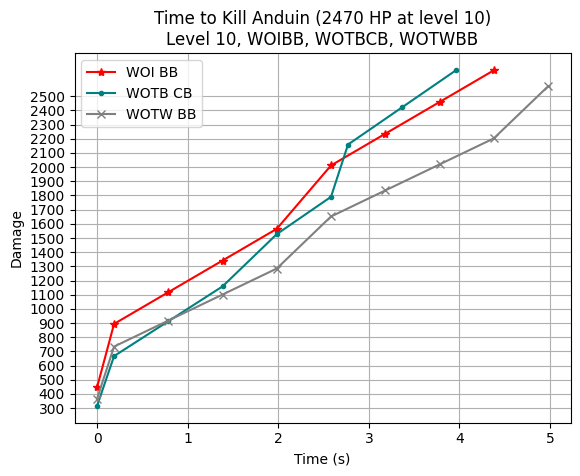

In [7]:
import matplotlib.pyplot as plt
plt.plot(bb_time_series_for_kill_target, bb_damage_series_for_kill_target, marker="*", label="WOI BB", color="red")
plt.plot(cb_time_series_for_kill_target, cb_damage_series_for_kill_target, marker='.', label="WOTB CB", color="teal")
plt.plot(bb_wotw_time_series_for_kill_target, bb_wotw_damage_series_for_kill_target, marker='x', label="WOTW BB", color="grey")
plt.xlabel("Time (s)")
plt.ylabel("Damage")
plt.title("Time to Kill Anduin (2470 HP at level 10)\nLevel 10, WOIBB, WOTBCB, WOTWBB")
plt.legend()
plt.grid()
plt.xticks(range(0, 6, 1))
plt.yticks(range(300, 2600, 100))

plt.show()

In [ ]:
bb_time_series, bb_damage_series = damage_calc(
    7,
    10,
    num_clones=0,
    num_clones_attacking=0,
    one_talent=OneTalents.WAYOFILLUSION,
    seven_talent=SevenTalents.BURNINGBLADE,
)
cb_time_series, cb_damage_series = damage_calc(
    7,
    10,
    num_clones=0,
    num_clones_attacking=0,
    one_talent=OneTalents.WAYOFILLUSION,
    seven_talent=SevenTalents.CRUSHINGBLOWS,
)